# Timing tests

This notebook runs all the classifiers with the easy-on-the-eyes dataset, and returns the runtimes for profiling.

## Instructions
1. Run the test with 1 voter
2. Change to desired number of voters and re-run the test. 
3. After 1 and 2, enable and run the last cell to save results.

## Import libraries

In [1]:
# Default libraries
import os
import re
import mne
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing
import pycuda.driver as cuda
import scipy.signal as signal
import matplotlib.pyplot as plt
from cupyx.profiler import benchmark


# Import custom libraries
from functions import data_tools
from functions import processing
from functions import classification
from functions.FeatureExtractorSSVEP import FeatureExtractorCCA as CCA
from functions.FeatureExtractorSSVEP import FeatureExtractorMSI as MSI
from functions.FeatureExtractorSSVEP import FeatureExtractorMEC as MEC

# Magic command to reload libraries
%reload_ext autoreload
# %autoreload 3

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.


To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.


c:\Users\danie\miniconda3\envs\ssvep-validation\Lib\site-packages\moabb\pipelines\__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


## CPU and GPU information

Get CPU and GPU information to save in results

In [2]:
# Get the number of processor types
short_name_processors = {
    "AMD64 Family 25 Model 33 Stepping 0, AuthenticAMD": "AMD Ryzen 7 5800X",
    "AMD64 Family 25 Model 80 Stepping 0, AuthenticAMD": "AMD Ryzen 7 5800HS",
    "NVIDIA GeForce RTX 3050 Laptop GPU": "NVIDIA GeForce RTX 3050"
    }

# Get CPU and GPU information
cpu_model = platform.processor()

cuda.init()
gpu_model = cuda.Device(0).name()

# Replace CPU and GPU names if they are in the dictionary
cpu_model = short_name_processors.get(cpu_model, cpu_model)
gpu_model = short_name_processors.get(gpu_model, gpu_model)

## Settings

In [ ]:
# Change data folder depending on the computer used
data_folder = r"C:\Users\danie\OneDrive - University of Calgary\PDF\Proyects\Datasets\easy-on-the-eyes"
data_files = [r"sub-P004\ses-S001\eeg\sub-P004_ses-S001_task-T1_run-001_eeg.xdf"]
# data_files = [r"sub-P015\ses-S001\eeg\sub-P015_ses-S001_task-T1_run-001_eeg.xdf"]
# data_files = [
#     r"sub-P003\ses-S001\eeg\sub-P003_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P004\ses-S001\eeg\sub-P004_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P005\ses-S001\eeg\sub-P005_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P006\ses-S001\eeg\sub-P006_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P007\ses-S001\eeg\sub-P007_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P008\ses-S001\eeg\sub-P008_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P009\ses-S001\eeg\sub-P009_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P010\ses-S001\eeg\sub-P010_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P011\ses-S001\eeg\sub-P011_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P012\ses-S001\eeg\sub-P012_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P015\ses-S001\eeg\sub-P015_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P016\ses-S001\eeg\sub-P016_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P019\ses-S001\eeg\sub-P019_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P020\ses-S001\eeg\sub-P020_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P021\ses-S001\eeg\sub-P021_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P022\ses-S001\eeg\sub-P022_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P023\ses-S001\eeg\sub-P023_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P024\ses-S001\eeg\sub-P024_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P025\ses-S001\eeg\sub-P025_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P026\ses-S001\eeg\sub-P026_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P027\ses-S001\eeg\sub-P027_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P028\ses-S001\eeg\sub-P028_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P029\ses-S001\eeg\sub-P029_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P030\ses-S001\eeg\sub-P030_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P031\ses-S001\eeg\sub-P031_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P033\ses-S001\eeg\sub-P033_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P034\ses-S001\eeg\sub-P034_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P035\ses-S001\eeg\sub-P035_ses-S001_task-T1_run-001_eeg.xdf",
#     r"sub-P036\ses-S001\eeg\sub-P036_ses-S001_task-T1_run-001_eeg.xdf",
#     ]
files = [os.path.join(data_folder, file) for file in data_files]

# Import and epoch data
eeg_channels = ["C3", "Cz", "C4", "T7", "T8", "P3", "Pz", "P4", "P7", "PO7", "POz", "P8", "PO8", "O1", "Oz", "O2"]
# eeg_channels = ["O1","Oz","O2"]
# stimulus_types = ['MaxContrast', 'WoodGrain', 'Worms', 'Voronoi', 'MinContrast', 'Checkerboard', 'Static'] # Complete list of stimulus types
stimulus_types = ["MaxContrast", "Checkerboard", "MinContrast"]
dict_of_stimuli = {0:" MaxContrast", 1:" Checkerboard", 2:" MinContrast"}
stimulus_freqs = {0:"9.090909", 1:"14.28571", 2:"33.33333"}
list_of_freqs = [float(freq) for freq in stimulus_freqs.values()]
event_labels = np.array([0,0,0,1,1,1,2,2,2])

# Preprocessing settings
fc_low = 0.1    # Cut frequency for the high-pass filter [Hz]
fc_high = 100   # Cut frequency for the low-pass filter [Hz]
order = 4       # Order of the Butterworth filter

# Results
results = pd.DataFrame(
    columns=[
        "Classifier",
        "Processor_type",
        "Processor_model",        
        "Voters_number",
        "Mean",
        "SD",                
        "All_runs"
        ])

## Classifier settings

In [ ]:
# Classifier settings
nharmonics = 2
first_column = np.arange(1, 40, 3)
second_column = np.full(first_column.shape, 40)
cca_filterbank = np.column_stack((first_column, second_column))
filter_order = 12
batch_size = 256
ncores = multiprocessing.cpu_count()
nvoters = 100 # Change number of voters depending on test

## Preprocesss data

Import, epoch, and preprocess data in CPU before starting

In [5]:
# Preallocate variables
classifier_data = [None] * len(files)

for (f,file) in enumerate(files):
    subject_number = re.findall(r'sub-P(\d+)', file)[0]

    # Import data and markers
    [eeg_time, eeg, srate] = data_tools.read_xdf(file)
    [marker_time, markers] = data_tools.read_xdf_unity_markers(file)

    # Bandpass filter the EEG
    eeg_filtered = processing.bandpass_filter(
        eeg = eeg,
        srate = srate,
        f_low = fc_low,
        f_high = fc_high,
        f_order = order
        )

    # Filter 60 Hz noise
    eeg = processing.line_filter(eeg=eeg, srate=srate, f_notch=60, f_order=4)

    # Epoch data
    [eeg_epochs, epoch_labels] = data_tools.epochs_from_unity_markers(
        eeg_time = eeg_time,
        eeg_data = eeg_filtered,
        marker_time = marker_time,
        marker_data = markers
        )

    # Get stimuli and frequencies labels
    fixed_labels = data_tools.fix_labels(epoch_labels)          # Fix labels that might be incorrect in pilot trials
    # dict_of_stimuli = data_tools.get_tvep_stimuli(fixed_labels) # Dictionary of unique stimulus
    dict_of_stimuli = {0: " MaxContrast", 1: " Checkerboard", 2: " MinContrast"}
    # - Create array of eeg epochs organized as [stimuli, freq, chans, samples]
    eeg_epochs_organized = data_tools.epochs_stim_freq(
        eeg_epochs = eeg_epochs,
        labels = fixed_labels,
        stimuli = dict_of_stimuli,
        freqs = stimulus_freqs,
        mode = "zeropad"
        )
    
    # Convert data to float32 to speed up computations
    # and reshape data to have all epochs in the same dimension
    classifier_data[f] = np.float32(eeg_epochs_organized.reshape(
        len(dict_of_stimuli) * len(event_labels),
        len(eeg_channels),
        eeg_epochs_organized.shape[-1],
        ))


## Timing profiler - CPU

### CCA

In [ ]:
def time_cca_cpu():
    for trial in classifier_data:
        cca_cpu = CCA()

        cca_cpu.setup_feature_extractor(
            harmonics_count = nharmonics,
            targets_frequencies = list_of_freqs,
            filter_order = filter_order,
            subbands = cca_filterbank,
            sampling_frequency = srate,
            use_gpu = False,
            samples_count = trial.shape[-1],
            explicit_multithreading = ncores,
            max_batch_size = batch_size,
            voters_count = nvoters
            )
        
        cca_cpu.extract_features(trial)

In [7]:
cca_cpu_results = %timeit -n 1 -r 5 -o \
time_cca_cpu()

12.3 s ± 264 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [8]:
new_row = pd.DataFrame({
    "Classifier": "fbCCA",
    "Processor_type": "CPU",
    "Processor_model": cpu_model,
    "Voters_number": nvoters,
    "Mean": cca_cpu_results.average,
    "SD": cca_cpu_results.stdev,
    "All_runs": [np.array(cca_cpu_results.all_runs)]
    })

results = pd.concat([results, new_row], ignore_index=True)

### MEC

In [9]:
def time_mec_cpu():
    for trial in classifier_data:
        mec_cpu = MEC()

        mec_cpu.setup_feature_extractor(
            harmonics_count = nharmonics,
            targets_frequencies = list_of_freqs,
            sampling_frequency = srate,
            use_gpu = False,
            samples_count = trial.shape[-1],
            explicit_multithreading = ncores,
            max_batch_size = batch_size,
            voters_count = nvoters
            )
            
        mec_cpu.extract_features(trial)

In [10]:
mec_cpu_results = %timeit -n 1 -r 5 -o \
time_mec_cpu()

51.6 s ± 503 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [11]:
new_row = pd.DataFrame({
    "Classifier": "MEC",
    "Processor_type": "CPU",
    "Processor_model": cpu_model,
    "Voters_number": nvoters,
    "Mean": mec_cpu_results.average,
    "SD": mec_cpu_results.stdev,
    "All_runs": [np.array(mec_cpu_results.all_runs)]
    })

results = pd.concat([results, new_row], ignore_index=True)

### MSI

In [12]:
def time_msi_cpu():
    for trial in classifier_data:
        msi_cpu = MSI()

        msi_cpu.setup_feature_extractor(
            harmonics_count = nharmonics,
            targets_frequencies = list_of_freqs,
            sampling_frequency = srate,
            use_gpu = False,
            samples_count = trial.shape[-1],
            explicit_multithreading = ncores,
            max_batch_size = batch_size,
            voters_count = nvoters
            )
            
        msi_cpu.extract_features(trial)

In [13]:
msi_cpu_results = %timeit -n 1 -r 5 -o \
time_msi_cpu()

2.57 s ± 68 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [14]:
new_row = pd.DataFrame({
    "Classifier": "MSI",
    "Processor_type": "CPU",
    "Processor_model": cpu_model,
    "Voters_number": nvoters,
    "Mean": msi_cpu_results.average,
    "SD": msi_cpu_results.stdev,
    "All_runs": [np.array(msi_cpu_results.all_runs)]
    })

results = pd.concat([results, new_row], ignore_index=True)

del msi_cpu_results

## Timing profiler GPU

### CCA

In [15]:
def time_cca_gpu():
    for trial in classifier_data:
        cca_gpu = CCA()

        cca_gpu.setup_feature_extractor(
            harmonics_count = nharmonics,
            subbands = cca_filterbank,
            filter_order = filter_order,
            targets_frequencies = list_of_freqs,
            sampling_frequency = srate,
            use_gpu = True,
            samples_count = trial.shape[-1],
            max_batch_size = batch_size,
            voters_count = nvoters
            )
        
        cca_gpu.extract_features(trial)

In [16]:
cca_gpu_results = benchmark(
    time_cca_gpu,
    n_repeat = 5,
    n_warmup = 5,
    devices = (0,)
    )

In [17]:
new_row = pd.DataFrame({
    "Classifier": "fbCCA",
    "Processor_type": "GPU",
    "Processor_model": gpu_model,
    "Voters_number": nvoters,
    "Mean": np.mean(cca_gpu_results.gpu_times),
    "SD": np.std(cca_gpu_results.gpu_times),
    "All_runs": [np.array(cca_gpu_results.gpu_times)]
    })

results = pd.concat([results, new_row], ignore_index=True)

### MEC

In [18]:
def time_mec_gpu():
    for trial in classifier_data:
        mec_gpu = MEC()

        mec_gpu.setup_feature_extractor(
            harmonics_count = nharmonics,
            targets_frequencies = list_of_freqs,
            sampling_frequency = srate,
            use_gpu = True,
            samples_count = trial.shape[-1],
            max_batch_size = batch_size,
            voters_count = nvoters
            )
        
        mec_gpu.extract_features(trial)

In [19]:
mec_gpu_results = benchmark(
    time_mec_gpu,
    n_repeat = 5,
    n_warmup = 5,
    devices = (0,)
    )

In [20]:
new_row = pd.DataFrame({
    "Classifier": "MEC",
    "Processor_type": "GPU",
    "Processor_model": gpu_model,
    "Voters_number": nvoters,
    "Mean": np.mean(mec_gpu_results.gpu_times),
    "SD": np.std(mec_gpu_results.gpu_times),
    "All_runs": [np.array(mec_gpu_results.gpu_times)]
    })

results = pd.concat([results, new_row], ignore_index=True)

### MSI

In [21]:
def time_msi_gpu():
    for trial in classifier_data:
        msi_gpu = MSI()

        msi_gpu.setup_feature_extractor(
            harmonics_count = nharmonics,
            targets_frequencies = list_of_freqs,
            sampling_frequency = srate,
            use_gpu = True,
            samples_count = trial.shape[-1],
            max_batch_size = batch_size,
            voters_count = nvoters
            )
        
        msi_gpu.extract_features(trial)

In [22]:
msi_gpu_results = benchmark(
    time_msi_gpu,
    n_repeat = 5,
    n_warmup = 5,
    devices = (0,)
    )

In [23]:
new_row = pd.DataFrame({
    "Classifier": "MSI",
    "Processor_type": "GPU",
    "Processor_model": gpu_model,
    "Voters_number": nvoters,
    "Mean": np.mean(msi_gpu_results.gpu_times),
    "SD": np.std(msi_gpu_results.gpu_times),
    "All_runs": [np.array(msi_gpu_results.gpu_times)]
    })

results = pd.concat([results, new_row], ignore_index=True)

## Plot results

Run this sections for a simple plot of the timing results. For a more detailed plot, use the [timing_plots](timing_plots.ipynb) notebook.

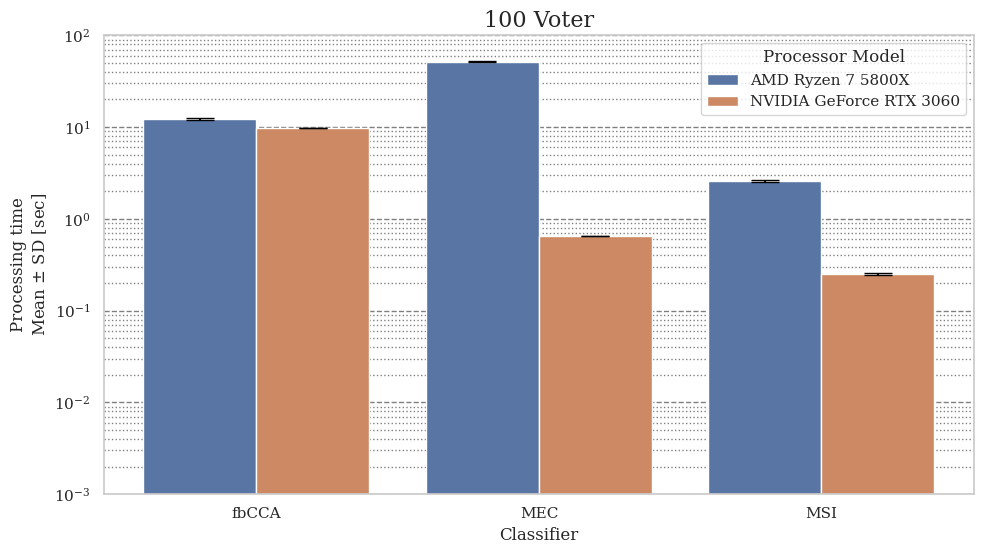

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the combined results
sns.barplot(
    data=results,
    x='Classifier',
    y='Mean',
    hue='Processor_type',
    ax=ax,
    capsize=0.1,
    alpha=1,
    zorder=2,
    palette='deep'  # Use the default matplotlib color scheme
)

# Add error bars
for i, classifier in enumerate(results['Classifier'].unique()):
    for j, processor_type in enumerate(results['Processor_type'].unique()):
        mean = results[(results['Classifier'] == classifier) & (results['Processor_type'] == processor_type)]['Mean']
        sd = results[(results['Classifier'] == classifier) & (results['Processor_type'] == processor_type)]['SD']
        x_pos = i + (j - 0.5) * 0.8 / len(results['Processor_type'].unique())  # Adjust x position for error bars
        ax.errorbar(x=x_pos, y=mean, yerr=sd, fmt='none', capsize=10, color='black', zorder=3)

# Set the gridlines to be black and behind the barplots
ax.grid(axis='y', linestyle='--', alpha=0.5, color='black', zorder=0)
ax.yaxis.grid(True, which='minor', linestyle=':', alpha=0.5, color='black', zorder=0)

# Set the y-axis scale to logarithmic
ax.set_yscale('log')
ax.set_ylim(1e-3, 1e2)

# Set the title and labels
ax.set_ylabel('Processing time\nMean $\pm$ SD [sec]')

# Add legend
handles, labels = ax.get_legend_handles_labels()
labels = [cpu_model if label == 'CPU' else gpu_model for label in labels]
ax.legend(handles, labels, title='Processor Model')

# Set the main title
ax.set_title(f'{nvoters} Voter', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Save results

In [25]:
save_results = False

if save_results:
    results.to_csv("results_ROG.csv")
